## LSTM class Developed
-----------------------------
[feat] 7/16
- ! to prevent overfitting use K-fold, validation split ! <- NEED TO DEVELOP
- basical LSTM model => lstm dense need to doubled
- not tested
- without AOC, interest rate
- bidirectional LSTM Model

[feat] 7/17

[need] 7/17
- val_loss 범위 설정
- k-fold 구현-> LSTM 구조상 폐기
- return값 설정
- 모델 예측 설정 방법

[feat] 7/19 V 1.0
- postscale...      (done)
- model test res... (done)
- predict range .. (done) (using loss mean square err)

[need] 7/19 V 1.0
- prediction res return function => ??input??
-





imorts & get datas
------------

In [1]:
#!pip install -U finance-datareader

#%pip install FinanceDataReader

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as pdr
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense ,LSTM, Dropout,Bidirectional
from sklearn.model_selection import train_test_split, KFold
from tensorflow import expand_dims
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from os.path import join
from tensorflow import constant
#import FinanceDataReader as fdr

In [3]:
data=pd.read_csv('/content/drive/MyDrive/2023_1st_vac/KRX_DATA/train.csv')

In [4]:
# prescaler
def getAOC(data):
  AOC = []
  close = data['종가']
  close_pre = close.shift(1)

  AOC.append(0)

  # aoc = (금일 종가 - 전일 종가) / 전일 종가
  for i in range(1, len(close)):
    aoc_value = ((close[i] - close_pre[i]) / close_pre[i]) * 100
    AOC.append(aoc_value)

  return AOC

#sort data by "종목명"
subject_Data=data.sort_values(by="종목명",inplace=False)
subject_Data.head()
subject_Data.columns

pv_s_data=pd.pivot_table(subject_Data,values=['거래량', '시가', '고가', '저가', '종가'],index=['종목코드','일자'])

divided = pv_s_data.index.get_level_values('종목코드').unique()

sliced_dataframes = []

for i in divided:
    sliced_data = pv_s_data.loc[i]
    sliced_dataframe = sliced_data.reset_index()
    sliced_dataframes.append(sliced_dataframe)

In [5]:
data=sliced_dataframes

In [6]:
data[0].shape

(494, 6)

## LSTM Obj

In [83]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as pdr
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense ,LSTM, Dropout,Bidirectional
from sklearn.model_selection import train_test_split, KFold
from tensorflow import expand_dims
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from os.path import join
from tensorflow import constant
#import FinanceDataReader as fdr

class LSTM_Object():

  def __init__(self,data):
    #get sliced data
    self.data=data

  def modeling(self):

    self.prescale()
    self.model=Sequential()
    #layers
    self.model.add(Bidirectional(LSTM(1024,return_sequences=True,input_shape=(self.time_steps, self.num_features))))
    #self.model.add(LSTM(1024,return_sequences=True,input_shape=(self.x_train.shape[1], self.x_train.shape[2])))
    #self.model.add(Dropout(0.25))
    #self.model.add(LSTM(1024,return_sequences=True,input_shape=(self.x_train.shape[1], self.x_train.shape[2])))
    #self.model.add(LSTM(1024,return_sequences=True,input_shape=(self.x_train.shape[1], self.x_train.shape[2])))
    #self.model.add(Dropout(0.25))
    self.model.add(Dense(512, activation='relu'))
    self.model.add(Dense(256, activation='relu'))
    self.model.add(Dense(128, activation='relu'))
    #self.model.add(LSTM(1024,return_sequences=True,input_shape=(self.x_train.shape[1], self.x_train.shape[2])))
    #output layer
    self.model.add(Dense(1, activation='relu'))

    self.filename = join('/content/drive/MyDrive/2023_1st_vac/KRX_modelings/tests', 'ckeckpointer.ckpt')
    checkpoint = ModelCheckpoint(self.filename, save_weights_only=True, save_best_only=True,monitor='val_loss',verbose=1)

    earlystopping = EarlyStopping(monitor='val_loss', patience=1000)
    self.model.compile(loss = 'mean_squared_error', optimizer=Adam(learning_rate=0.001))
    self.history=self.model.fit(self.x_train,self.y_train,epochs=100,batch_size=128,validation_data=(self.x_val,self.x_val),shuffle=False,callbacks=[checkpoint, earlystopping])


  def prescale(self):
    x_scaler = MinMaxScaler()
    self.y_scaler = MinMaxScaler()
    # Scaling features
    x_data = self.data[['거래량', '고가', '시가', '저가']]
    x_data = x_scaler.fit_transform(x_data)
    # Scaling target variable (종가)
    y_data = self.data['종가']
    y_data = self.y_scaler.fit_transform(y_data.values.reshape(-1, 1))
    # validation set
    x_train_p, x_test, y_train_p, y_test = train_test_split(x_data, y_data, test_size=0.2, shuffle=False)
    x_train, x_val, y_train, y_val = train_test_split(x_train_p, y_train_p, test_size=0.25, shuffle=False)
    ### reshape input datas()


    self.num_features = x_data.shape[1]
    self.num_samples=x_data.shape[0]
    self.time_steps=30

    self.x_train = self.create_sequences(x_train)
    self.x_test = self.create_sequences(x_test)
    self.x_val = self.create_sequences(x_val)

    self.y_train=self.create_sequences(y_train)
    self.y_test=self.create_sequences(y_test)
    self.y_val=self.create_sequences(y_val)


  def create_sequences(self, data):
    num_samples, num_features = data.shape
    sequences = []
    for i in range(num_samples - self.time_steps +1):
      sequences.append(data[i:i + self.time_steps, :])
    return np.array(sequences)

  def create_sequences_y(self, data):
    num_samples, num_features = data.shape
    sequences = []
    for i in range(num_samples - self.time_steps +1):
      sequences.append(data[i:i + self.time_steps, :])
    return np.array(sequences)


  def ret_learning(self):
    # rescale to get real value

    self.prescale()
    self.modeling()
    self.model.load_weights(self.filename)
    pred = self.model.predict(self.x_test)

    rescaled_pred = self.y_scaler.inverse_transform(np.array(pred.flatten()).reshape(-1,1))
    rescaled_real = self.y_scaler.inverse_transform(np.array(self.y_test).reshape(-1,1))

    k=0
    for i in rescaled_pred:
      print("predict: {}, real: {}".format(i,rescaled_real[k]))
      k+=1



    plt.figure(figsize=(12, 9))
    plt.plot(rescaled_real, label='actual')
    plt.plot(rescaled_pred, label='prediction')
    plt.legend()
    plt.show()

In [84]:
test_1=data[0]

In [85]:
L=LSTM_Object(test_1)
L.prescale()

In [86]:
L.num_samples

494

In [87]:
L.x_test.shape

(70, 30, 4)

Epoch 1/100
2/3 [===================>..........] - ETA: 0s - loss: 0.2101 
Epoch 1: val_loss improved from inf to 0.00266, saving model to /content/drive/MyDrive/2023_1st_vac/KRX_modelings/tests/ckeckpointer.ckpt
3/3 [==============================] - 10s 700ms/step - loss: 0.2056 - val_loss: 0.0027
Epoch 2/100
2/3 [===================>..........] - ETA: 0s - loss: 0.0165
Epoch 2: val_loss improved from 0.00266 to 0.00200, saving model to /content/drive/MyDrive/2023_1st_vac/KRX_modelings/tests/ckeckpointer.ckpt
3/3 [==============================] - 1s 320ms/step - loss: 0.0160 - val_loss: 0.0020
Epoch 3/100
2/3 [===================>..........] - ETA: 0s - loss: 0.0152
Epoch 3: val_loss did not improve from 0.00200
3/3 [==============================] - 0s 81ms/step - loss: 0.0149 - val_loss: 0.0084
Epoch 4/100
2/3 [===================>..........] - ETA: 0s - loss: 0.0320
Epoch 4: val_loss improved from 0.00200 to 0.00170, saving model to /content/drive/MyDrive/2023_1st_vac/KRX_modelin

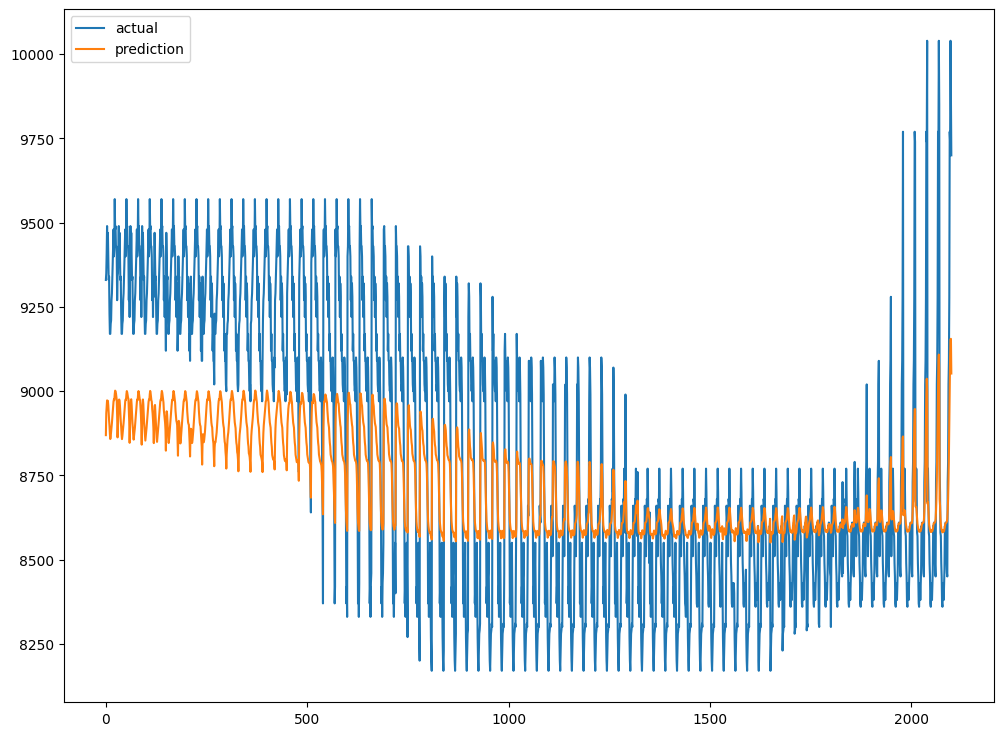

In [88]:
L.ret_learning()